# Multivariate analysis of countries by electricity production
-----
### The project below is concentrated on cluster analysis and linear ordering. The purpose of the analysis was to group world-wide countries according to the main sources of electricity produced and to identify the greenest countries in terms of their use of renewable and non-renewable energy sources.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.spatial.distance import pdist, cdist, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, ward, single, complete, average, cut_tree

In [2]:
%matplotlib notebook

## Loading the dataset
-----
The data was obtained from the website [kaggle.com](https://www.kaggle.com/datasets/prateekmaj21/electricity-production-by-source-world).

In [39]:
fulldata = pd.read_csv('YourPath/Electricity_Production_By_Source.csv')

#The analysis will be performed on the most current data available in the dataset (which is 2020).
data2020 = fulldata[fulldata['Year'] == 2020]
data2020.set_index('Entity', inplace = True)
data2020.head(10)

,Code,Year,Electricity from coal (TWh),Electricity from gas (TWh),Electricity from hydro (TWh),Electricity from other renewables (TWh),Electricity from solar (TWh),Electricity from oil (TWh),Electricity from wind (TWh),Electricity from nuclear (TWh)
Entity,,,,,,,,,,
Argentina,ARG,2020,1.445719,86.689660,20.853642,1.893496,1.344267,3.492022,9.419758,10.010408
Australia,AUS,2020,135.099330,48.132519,16.112890,3.443160,18.638820,5.612541,24.308719,0.000000
Austria,AUT,2020,0.716660,10.440827,42.883119,4.068629,1.264996,3.249908,6.868170,0.000000
Azerbaijan,AZE,2020,0.000000,12.514432,1.549350,0.155333,0.044000,11.379848,0.135000,0.000000
Bangladesh,BGD,2020,4.423591,56.552108,0.697582,0.002942,0.417096,18.308803,0.006000,0.000000
Belarus,BLR,2020,0.000000,34.895980,0.344520,0.336000,0.181000,0.000000,0.178000,0.000000
Belgium,BEL,2020,0.091300,26.052380,0.273023,5.171874,4.609734,3.545619,12.387557,33.790810
Bolivia,BOL,2020,0.000000,5.920966,2.915008,0.269000,0.251824,0.000000,0.063990,0.000000
Bosnia and Herzegovina,BIH,2020,10.755464,0.000000,4.852732,0.010667,0.030000,0.000000,0.235768,0.000000


In [40]:
#Among the imported data, there are entities that accumulate multiple countries - they need to be removed to provide reliable results.
data2020.drop(index=['EU-27','EU27+1','World'], inplace=True)
data2020.drop(columns=['Year','Code'], inplace=True)

#Renaming the columns - the original ones are too long and may occupy unnecessary space, for example, on charts 
#(all variables are expressed in the same unit).
data2020 = data2020.rename(columns={'Electricity from coal (TWh)':'Coal', 'Electricity from gas (TWh)':'Gas', 'Electricity from hydro (TWh)':'Hydro',
                                   'Electricity from other renewables (TWh)':'Other renewables', 'Electricity from solar (TWh)':'Solar', 'Electricity from oil (TWh)':'Oil',
                                   'Electricity from wind (TWh)':'Wind', 'Electricity from nuclear (TWh)':'Nuclear'})

C:\Users\Ania\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Data preparation
-------
#### Missing data analysis

<IPython.core.display.Javascript object>


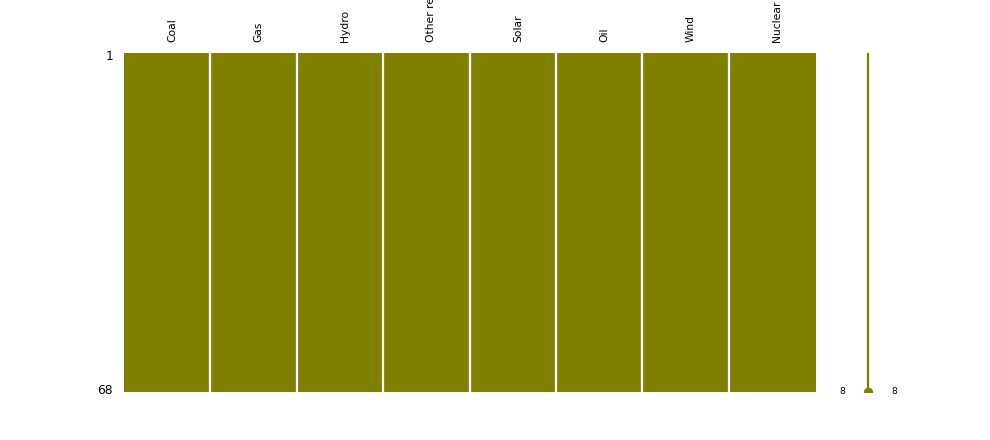

<AxesSubplot:>

In [41]:
#Data will be validate for missing values. Based on the missing data graph below, it can be quickly verified by looking for 
#gaps within the bars representing each variable.

msno.matrix(data2020, figsize=(9, 4), fontsize = (7), color=(0.5, 0.5, 0.0), label_rotation = 90)
#As no gap was identified we can conclude that there is no missing values.

#### Basic descriptive statistics

Analysing the following statistics, the most noticeable aspect is the standard deviation, which is unusually high. However, the data analysis methods used do not require the assumption of a normal distribution of variables. Additionally, the exclusion of countries with special values from the dataset can greatly impoverish the analysis and deprive it of valuable conclusions.

In [70]:
data2020.describe().round(2)

,Coal,Gas,Hydro,Other renewables,Solar,Oil,Wind,Nuclear
count,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00
mean,123.60,69.49,57.31,9.52,12.01,10.18,23.07,38.45
std,575.43,207.15,178.15,21.11,37.07,24.56,70.75,114.86
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.07,2.12,1.87,0.31,0.18,0.17,0.39,0.00
50%,4.87,16.67,7.43,2.24,1.25,2.44,2.61,0.00
75%,35.44,56.30,33.25,7.60,6.76,8.64,13.19,23.24
max,4631.21,1629.24,1355.20,129.74,261.10,160.32,466.50,789.92


#### Correlation
An important aspect of the pre-analysis for multivariate analysis, is to follow the correlation matrix. Too strong correlation between variables can result in accumulation of objects in a single cluster, redundancy of information (correlation equal to 0.9 may cause the loss of information up to 20%), or affect the ranking obtained from linear ordering (same with too low correlation).

<IPython.core.display.Javascript object>


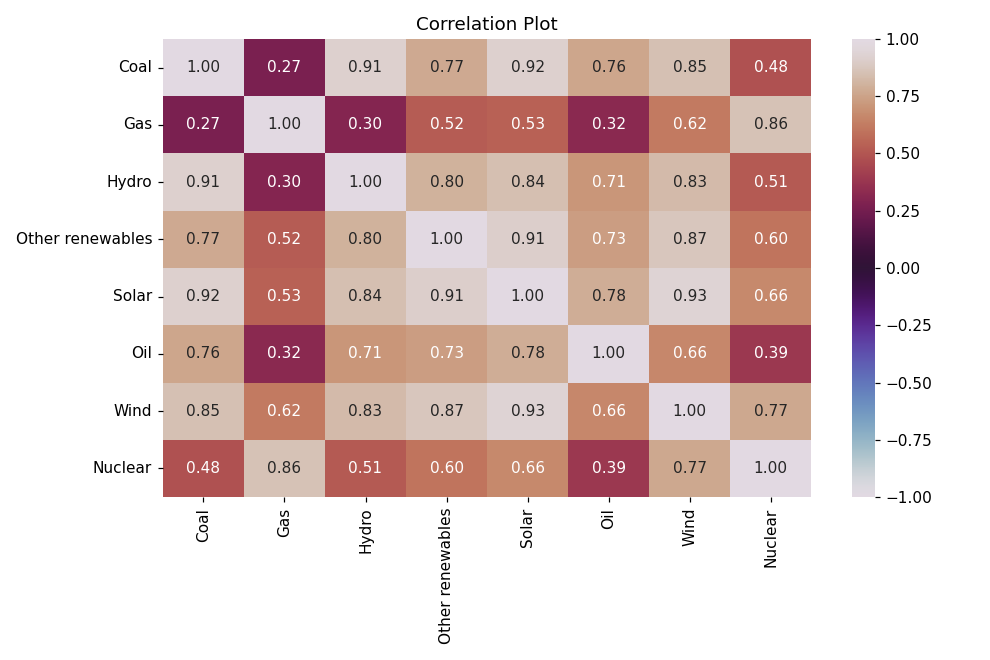

In [43]:
#Correlation heatmap
plt.subplots(figsize=(9, 6))
sns.heatmap(data2020.corr(), annot=True, cmap='twilight', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.tight_layout()

Results indicate moderate correlation for the majority of variables, thereby allowing all of them to be used for further analysis.

## Preliminary data analysis
-----
Before proceeding with the actual analysis, you can additionally take a superficial look at the data. In the chart below, it is possible to deduce which source (renewable or non-renewable) is most likely to be used in a global context to produce electricity.

<IPython.core.display.Javascript object>


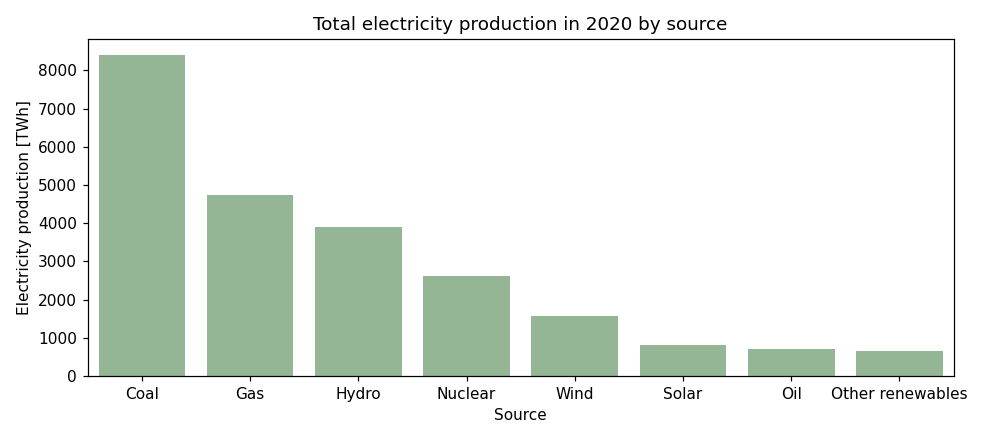

In [44]:
grouped = data2020.sum(axis=0).sort_values(ascending=False)
plt.subplots(figsize=(9,4))
ax = sns.barplot(x=grouped.index, y=grouped, color='darkseagreen')
ax.set(xlabel='Source', ylabel='Electricity production [TWh]')
plt.title('Total electricity production in 2020 by source')
plt.tight_layout()

At this point we can also distinguish 10 countries with the highest volume of eletricity produced. 

<IPython.core.display.Javascript object>


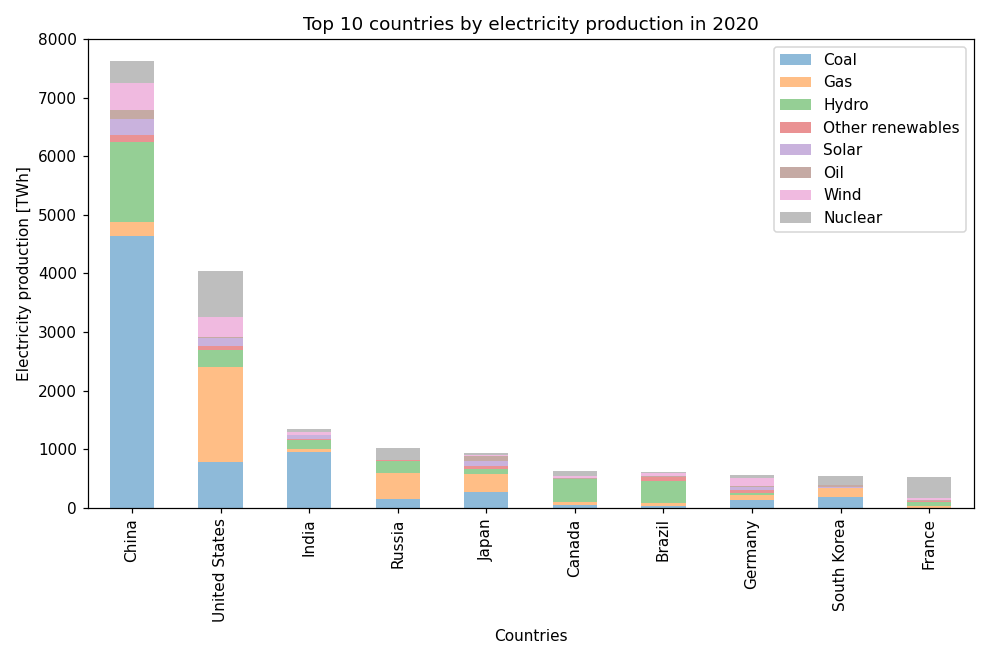

In [45]:
data2020.loc[data2020.sum(axis=1).nlargest(10).index].plot.bar(stacked=True, alpha=0.5, figsize=(9, 6))
plt.legend(loc='best')
plt.title('Top 10 countries by electricity production in 2020')
plt.ylabel('Electricity production [TWh]')
plt.xlabel('Countries')
plt.tight_layout()

To highlight the proportion of energy sources used, the data will be transformed so that their values will sum up to 1 (by dividing each value in a row by the sum of the values in that particular row).

<IPython.core.display.Javascript object>


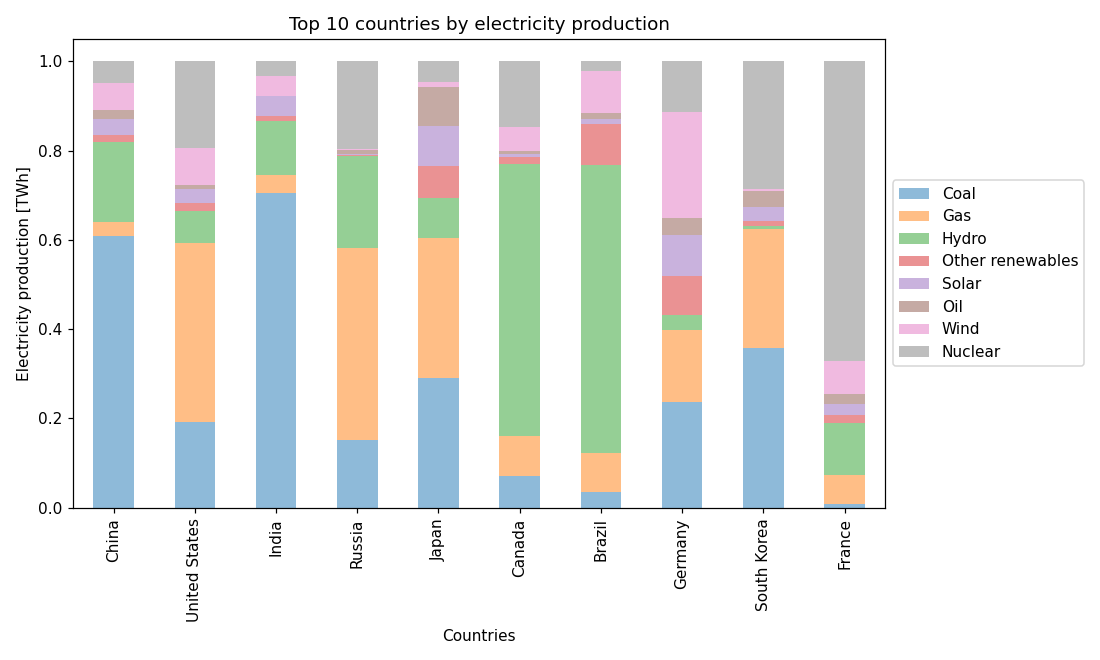

In [46]:
normalized_data = data2020.div(data2020.sum(axis=1), axis=0)
top_10_data = normalized_data.loc[data2020.sum(axis=1).nlargest(10).index]

fig, ax = plt.subplots(figsize=(10, 6))
top_10_data.plot.bar(stacked=True, alpha=0.5, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title('Top 10 countries by electricity production')
plt.ylabel('Electricity production [TWh]')
plt.xlabel('Countries')

plt.tight_layout()

## Hierarchical clustering
------

<IPython.core.display.Javascript object>


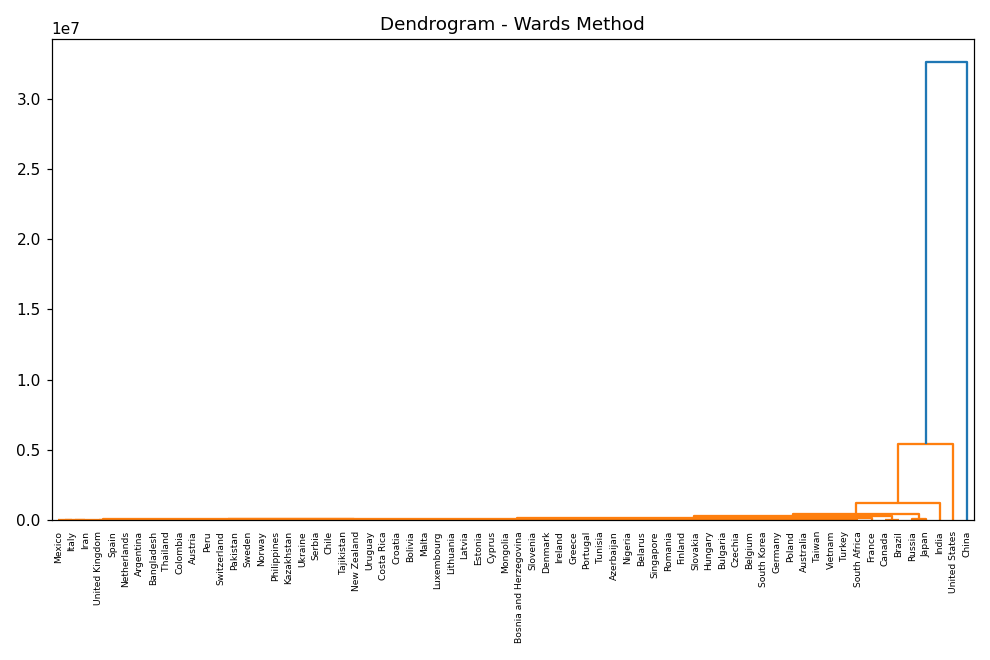

In [74]:
#The squared Euclidean distance was used (it should be mentioned that it is a mandatory distance for Ward's method, 
#which is the main point of cluster analysis in this project).
distance = pdist(data2020, metric='euclidean')**2 

#Clustering using Ward's method and clusters visualization using a dendrogram.
dendrogram_data = linkage(distance, method='ward')

plt.figure(figsize=(9, 6))
dendrogram(dendrogram_data, orientation='top', distance_sort='descending', labels=data2020.index)
plt.title('Dendrogram - Wards Method')
plt.tight_layout()

The clusters formed by Ward's method did not show a broad agglomeration structure. In this case it is worth to collide several methods at the same time to reach a final conclusion indicating whether the exclusion of some countries (forming individual clusters) is necessary.

<IPython.core.display.Javascript object>


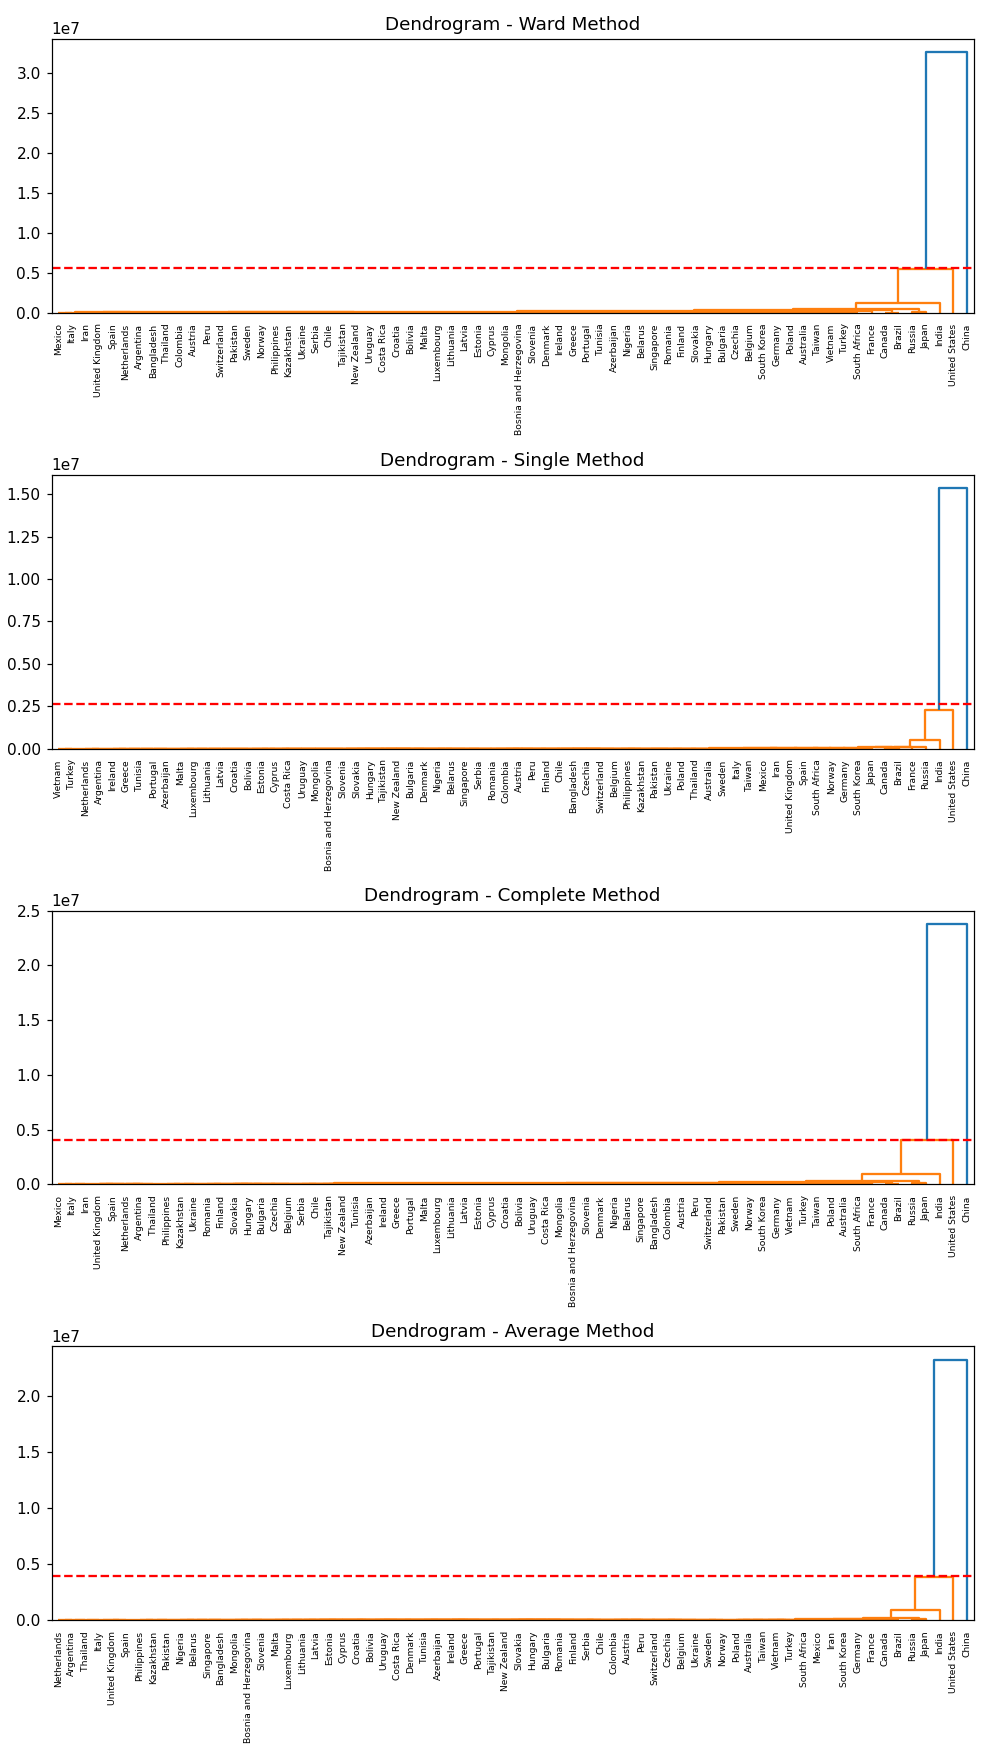

In [75]:
linkage_methods = ['ward','single', 'complete', 'average']

plt.figure(figsize=(9, 16))
for i, methods in enumerate(linkage_methods, start=1):
    dendrogram_data = linkage(distance, method=methods)
    
    plt.subplot(4, 1, i)
    dendrogram(dendrogram_data, orientation='top', distance_sort='descending', labels=data2020.index)
    
    #Calculating Mojena criteria to find a cut point.
    high = np.concatenate([[0], dendrogram_data[:, 2]])
    a = 1.25
    mojena = np.mean(high) + a * np.std(high)
    plt.axhline(y=mojena, color='red', linestyle='--')
    
    plt.title(f'Dendrogram - {methods.capitalize()} Method')

plt.tight_layout()

No matter which method is used, usually the dominance of China, USA and India over the other countries is clear (resulting in 2 or 3 single clusters and 1 full of other countries).

It was therefore decided to exclude these countries due to the distortion of possible interpretations.

<IPython.core.display.Javascript object>


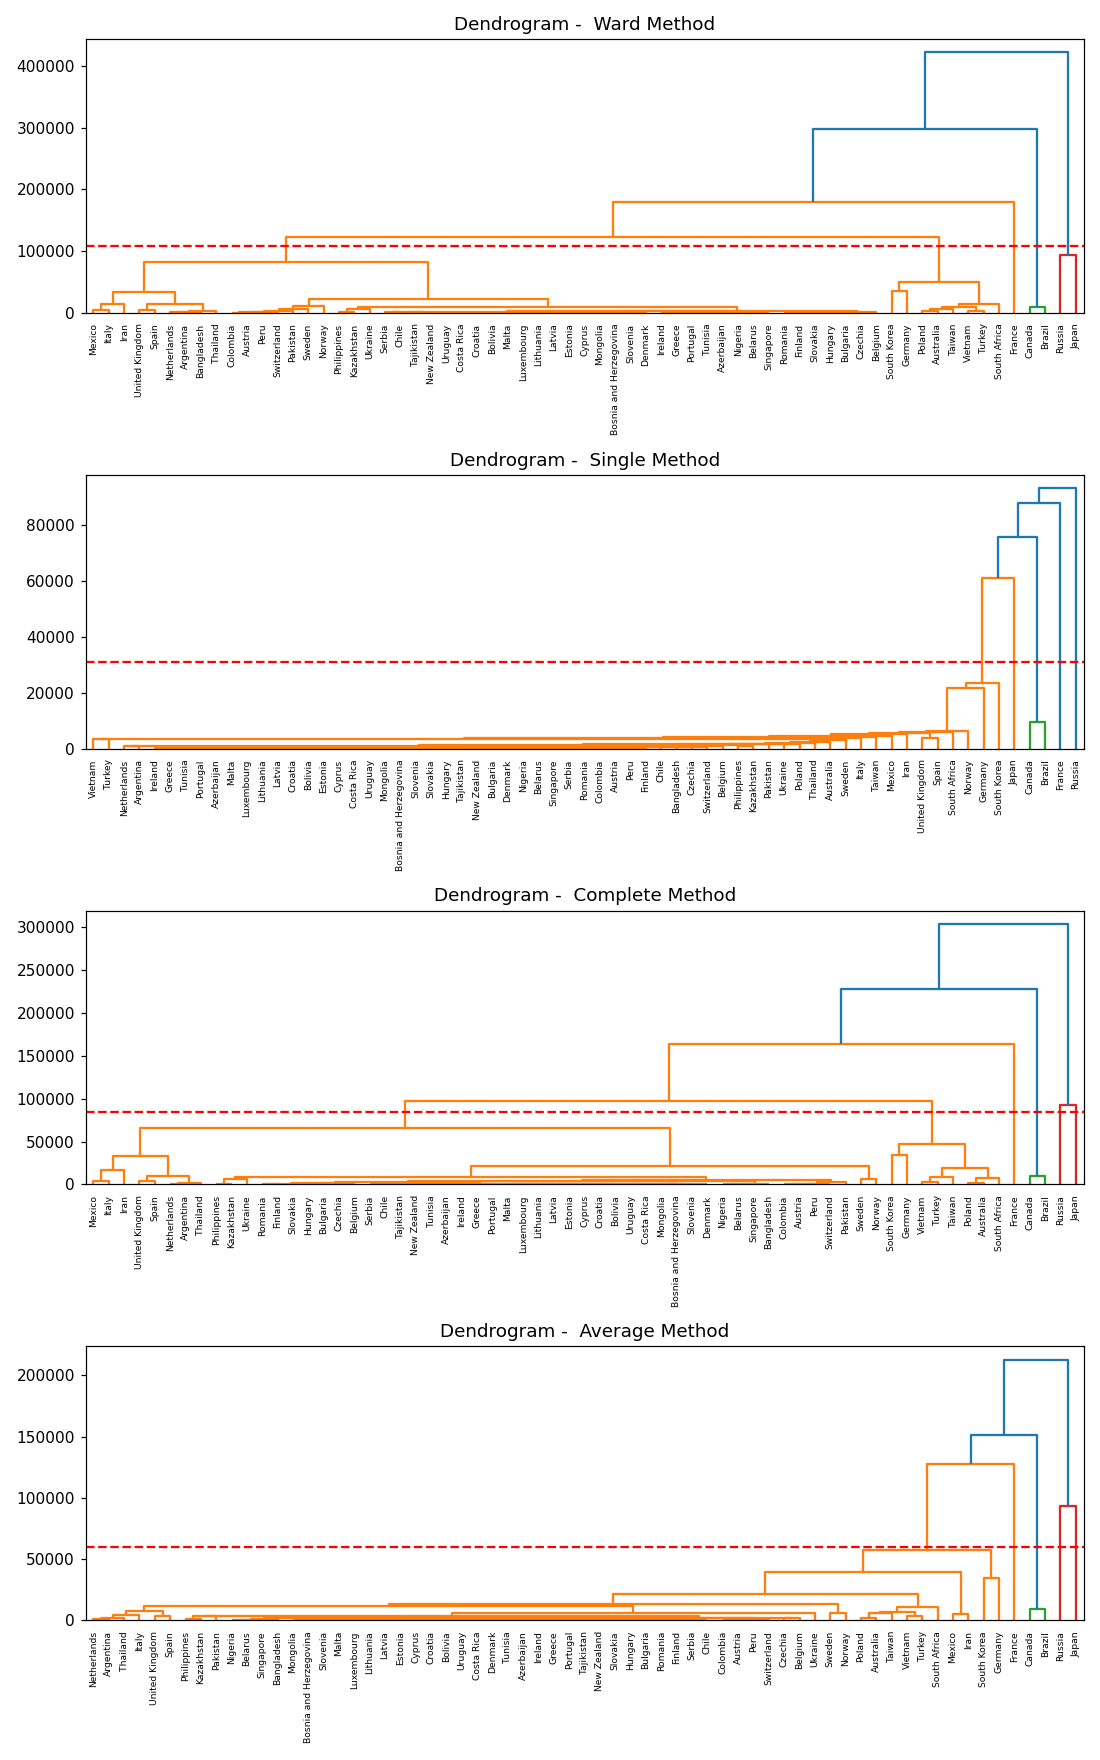

In [76]:
data2020_dom = data2020.drop(['China', 'United States', 'India'], axis=0)
distance = pdist(data2020_dom, metric='euclidean')**2

#Redoing dendrograms on updated data
linkage_methods = ['ward','single', 'complete', 'average']

plt.figure(figsize=(10, 16))
for i, methods in enumerate(linkage_methods, start=1):
    dendrogram_data = linkage(distance, method=methods)
    
    plt.subplot(4, 1, i)
    dendrogram(dendrogram_data, orientation='top', distance_sort='descending', labels=data2020_dom.index)
    
    high = np.concatenate([[0], dendrogram_data[:, 2]])
    a = 1.25
    mojena = np.mean(high) + a * np.std(high)
    plt.axhline(y=mojena, color='red', linestyle='--')
    
    plt.title(f'Dendrogram -  {methods.capitalize()} Method')

plt.tight_layout()

#### Cophenetic correlation coefficient
Based on the created dendrograms, it is also possible to verify whether they faithfully measures pairwise distances between the original unmodeled data points. For this purpose (mind that this is one of the several possible options available), cophenetic correlation will be used. A higher value of cophenetic correlation usually means a better representation of the data.

In [78]:
dendrogram_ward = linkage(distance, method='ward')
dendrogram_single = linkage(distance, method='single')
dendrogram_complete = linkage(distance, method='complete')
dendrogram_average = linkage(distance, method='average')

coph1, c1 = cophenet(dendrogram_ward, distance)
coph2, c2 = cophenet(dendrogram_single, distance)
coph3, c3 = cophenet(dendrogram_complete, distance)
coph4, c4 = cophenet(dendrogram_average, distance)

#Inserting the results into the df
cophenetic_correlation = pd.DataFrame({'Ward': [coph1], 'single': [coph2], 'complete': [coph3], 'average': [coph4]})

print("Cophenetic correlation coefficients:")
cophenetic_correlation.round(3)

Cophenetic correlation coefficients:


,Ward,single,complete,average
0,0.916,0.939,0.916,0.959


According to the results of the cophenetic correlation, the best adapted method is average. However, this method in substance tends to maximize this particular coefficient. All of the methods used indicate a sufficient summary of the observed differences between the examined countries (results above 0.9). We will take a closer look at the clusters formed based on the Ward's method, as it is the most sensitive to data clustered in equally sized districts.

#### Dendrogram - Ward's method (final form)
-----

<IPython.core.display.Javascript object>


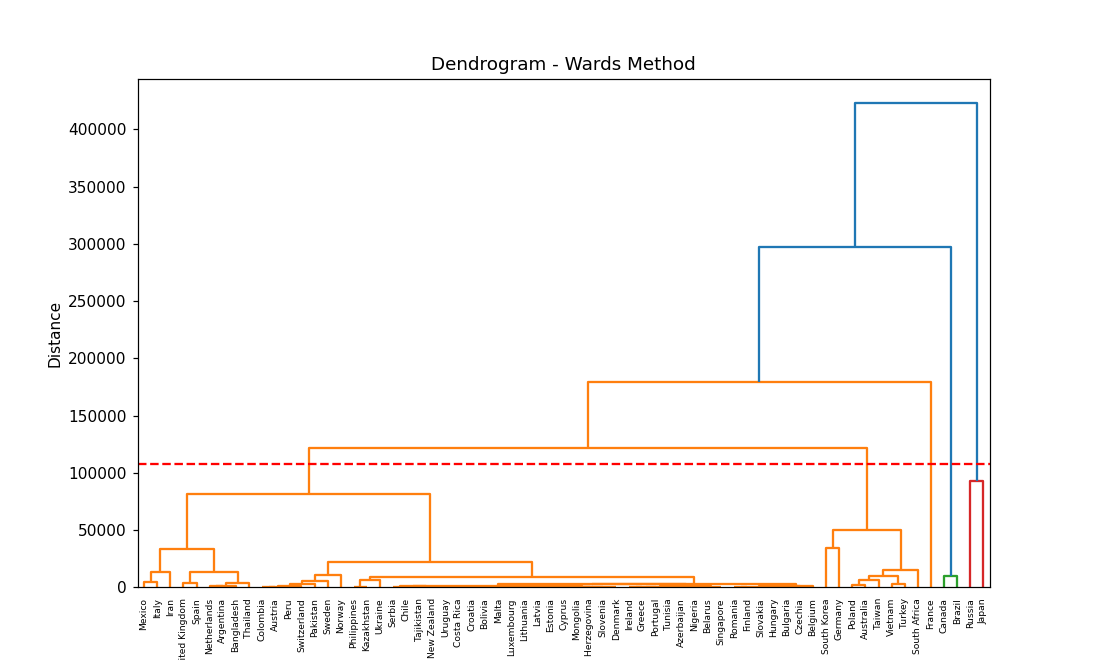

Countries assigned to clusters:


,Countries
Cluster,
0,"Argentina, Austria, Azerbaijan, Bangladesh, Belarus, Belgium, Bolivia, Bosnia and Herzegovina, Bulgaria, Chile, Colombia, Costa Rica, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, Greece, Hungary, Iran, Ireland, Italy, Kazakhstan, Latvia, Lithuania, Luxembourg, Malta, Mexico, Mongolia, Netherlands, New Zealand, Nigeria, Norway, Pakistan, Peru, Philippines, Portugal, Romania, Serbia, Singapore, Slovakia, Slovenia, Spain, Sweden, Switzerland, Tajikistan, Thailand, Tunisia, Ukraine, United Kingdom, Uruguay"
1,"Australia, Germany, Poland, South Africa, South Korea, Taiwan, Turkey, Vietnam"
2,"Brazil, Canada"
3,France
4,"Japan, Russia"


In [80]:
plt.figure(figsize=(10, 6))
dendrogram(dendrogram_ward, orientation='top', distance_sort='descending', labels=data2020_dom.index)
plt.title('Dendrogram - Wards Method')
plt.ylabel('Distance')

high = np.concatenate([[0], dendrogram_ward[:, 2]])
a = 1.25
mojena = np.mean(high) + a * np.std(high)
plt.axhline(y=mojena, color='red', linestyle='--')

#The table below the dendrogram will be indicating the country's affiliation to each cluster.
pd.set_option('display.max_colwidth', None)

clusters = cut_tree(dendrogram_ward, height=mojena).flatten()
data2020_dom['Cluster'] = clusters

cluster_assignment_df = pd.DataFrame(index=data2020_dom.index, columns=['Cluster'])
cluster_assignment_df['Cluster'] = clusters.flatten()
grouped_countries = cluster_assignment_df.groupby('Cluster').apply(lambda x: ', '.join(x.index))
result_df = pd.DataFrame(grouped_countries, columns=['Countries'])

print('Countries assigned to clusters:')
result_df

#### Clusters characteristics (average value of each variable)

In [82]:
cluster_means = data2020_dom.groupby('Cluster').mean()
cluster_means.round(2)

,Coal,Gas,Hydro,Other renewables,Solar,Oil,Wind,Nuclear
Cluster,,,,,,,,
0,8.36,27.09,14.86,3.84,2.44,6.17,6.77,8.61
1,139.82,62.86,23.76,10.58,15.72,8.24,26.45,32.41
2,33.18,54.23,386.78,32.46,5.99,6.05,45.14,53.19
3,4.28,34.25,62.06,8.79,13.19,11.53,39.23,355.19
4,214.48,368.29,147.25,35.65,43.06,46.10,5.98,122.73


**Analysing the characteristics of each cluster, the following conclusions arise:**

*Cluster 0:*

Characterized by an even distribution of energy production from different sources (including both non-renewable and renewable sources).

*Cluster 1:*

It brings countries together that rely heavily on gas and coal as a source of energy.

*Cluster 2:*

Clearly dominated by energy production from renewable sources, especially hydro and wind power.
Countries included in that cluster are apparently investing heavily in renewable energy sources.

*Cluster 3:*

This cluster basically includes one country (France) with a significant contribution to its energy mix from nuclear power.

*Cluster 4:*

Contains countries that rely heavily on non-renewable energy sources, such as gas, oil and coal, but also non-renewable - mainly hydro and nuclear.

The classification of countries into the above clusters, clearly provides an understanding of what energy strategies each region of the world has adopted.

#### Visualization of cluster profiles
The characteristics of clusters may also be expressed graphically.

<IPython.core.display.Javascript object>


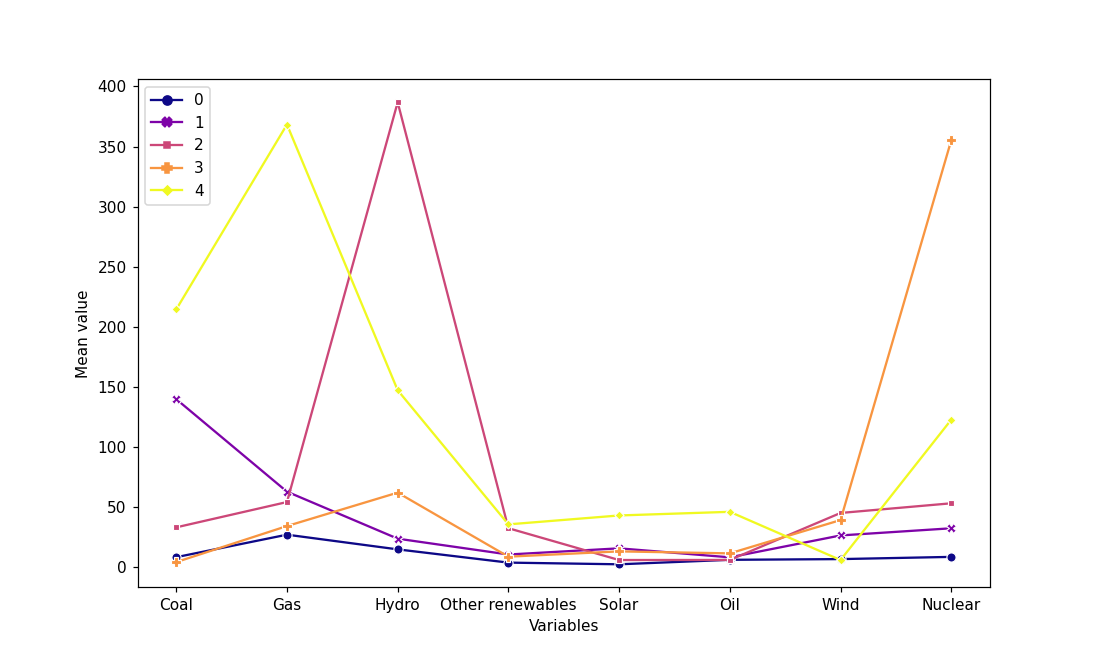

In [58]:
profile = data2020_dom.groupby('Cluster').mean().T
profile['Variables'] = profile.index

df2 = pd.melt(profile, id_vars=['Variables'], var_name='agglomeration', value_name='Mean value')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df2, x='Variables', y='Mean value', hue='agglomeration', style='agglomeration', markers=True, dashes=False, palette='plasma')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

## Linear ordering - Hellwig's method (Pattern of Development)
------

When it comes to ordering, the analysis will be based on all objects (without excluding dominant entities, as in cluster analysis). Ordering focuses on selecting the countries characterized by the greatest sustainability due to their use of a high proportion of renewable sources.

In the first step, it is necessary to determine whether the variables are stimulants or dissimulants.

In [61]:
stimulants = ['Hydro', 'Other renewables', 'Solar', 'Wind', 'Nuclear'] #renewable sources
disstimulants = ['Coal', 'Gas', 'Oil'] #non-renewable sources

Then, determine the pattern and anti-pattern

In [62]:
pattern = data2020[stimulants].max().append(data2020[disstimulants].min())
antipattern = data2020[stimulants].min().append(data2020[disstimulants].max())

Next - determination of the distance between each object and the pattern (the Pattern of Development method is based on Euclidean distance), and between the pattern and anti-pattern.

In [63]:
distance_pattern = cdist(data2020[stimulants + disstimulants], [pattern], metric='euclidean').flatten()

#Euclidean distance between the pattern and anti-pattern.
distance_antipattern = np.sqrt(np.sum((pattern - antipattern) ** 2))

The final step is to determine a taxonomic measure of development.

In [83]:
#Measure of development as distance from the pattern of development (MOD)
MOD = 1 - distance_pattern / distance_antipattern
#MOD

The measures, ranked from largest to smallest, create a ranking of countries starting with the most environmentally friendly (due to electricity production).

In [84]:
ranking = pd.DataFrame({'Country': data2020.index, 'Measure of Development': MOD.flatten().round(3)})
ranking = ranking.sort_values(by='Measure of Development', ascending=False).reset_index(drop=True)
ranking.index = ranking.index + 1

pd.set_option('display.max_rows', None)
ranking

,Country,Measure of Development
1,Canada,0.748
2,Brazil,0.743
3,France,0.719
4,Russia,0.715
5,Norway,0.700
6,Sweden,0.697
7,Germany,0.695
8,Spain,0.693
9,Turkey,0.692
10,Japan,0.690


#### Graphic visualization of the ranking

<IPython.core.display.Javascript object>


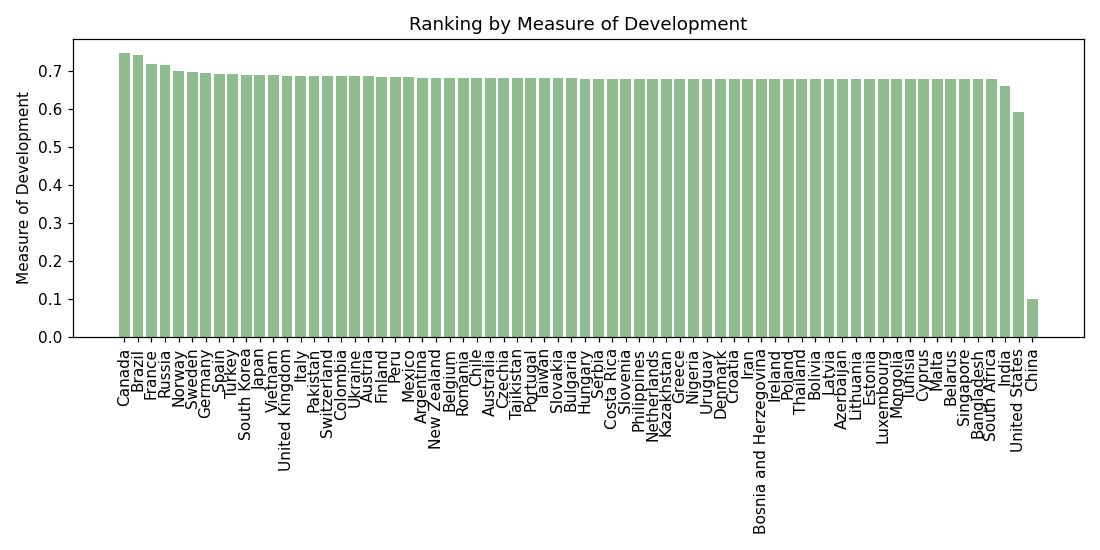

In [66]:
plt.figure(figsize=(10,5))
plt.bar(ranking['Country'], ranking['Measure of Development'], color='darkseagreen')
plt.ylabel('Measure of Development')
plt.title('Ranking by Measure of Development')
plt.xticks(rotation=90)
plt.tight_layout()

Countries in the middle part of the chart are characterized by a small variety of development measures - therefore we will focus on **the first 6 and last 6 places.**

<IPython.core.display.Javascript object>


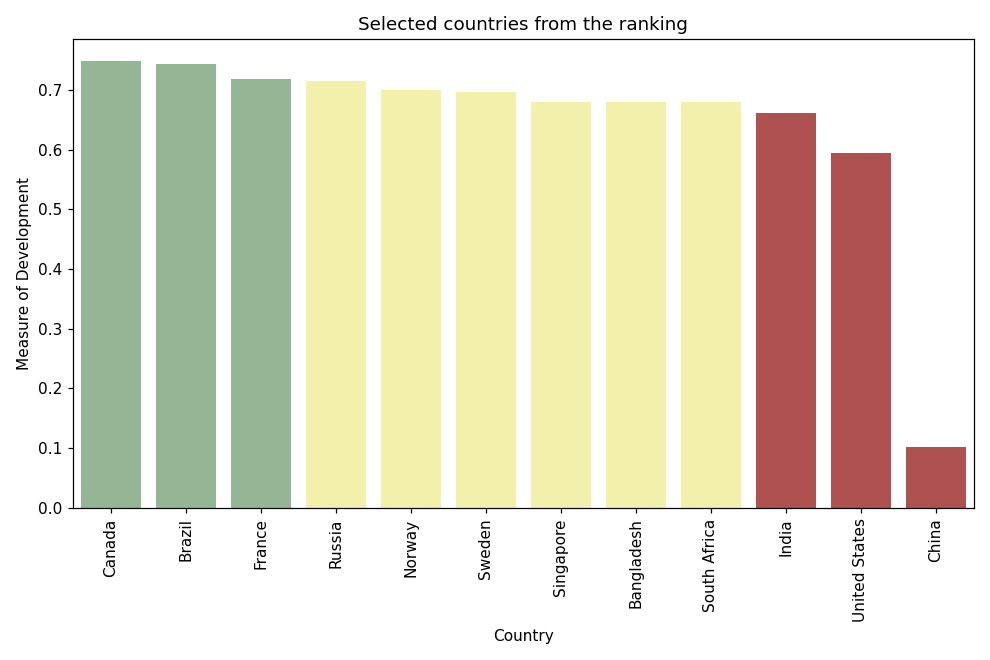

In [67]:
plt.figure(figsize=(9, 6))
selected_positions = pd.concat([ranking.head(3).assign(color='darkseagreen'), ranking.iloc[3:6].assign(color='#FFFBA0'), ranking.iloc[-6:-3].assign(color='#FFFBA0'), ranking.tail(3).assign(color='#BF4141')])

selected_positions['color'] = selected_positions['color'].fillna('red')  # Uzupełnienie brakujących kolorów jako zielone
palette = sns.color_palette(selected_positions['color'])
sns.barplot(x='Country', y='Measure of Development', data=selected_positions, palette=palette)

plt.title('Selected countries from the ranking')
plt.ylabel('Measure of Development')
plt.xticks(rotation=90)
plt.tight_layout()